In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

import tqdm
import seaborn as sns
import numpy.testing as np_testing
from sklearn.metrics import precision_recall_curve, roc_curve

from IPython.display import clear_output

sns.set(font_scale=1.5, rc={'figure.figsize':(11.7, 8.27)})

Ploting functions, nothing to do here...

In [2]:
def plot_level_lines(model, data, labels, size=100):
    def _expand(a, b, frac=.5, margin=1.):
        return a - abs(a) * frac - margin, b + abs(b) * frac + margin

    plt.figure(figsize=(10, 7))
    min_x, min_y = data.min(axis=0)
    max_x, max_y = data.max(axis=0)
    min_x, max_x = _expand(min_x, max_x)
    min_y, max_y = _expand(min_y, max_y)

    all_x = np.linspace(min_x, max_x, num=size)
    all_y = np.linspace(min_y, max_y, num=size)
    XX, YY = np.meshgrid(all_x, all_y)
    test_data = np.c_[XX.ravel(), YY.ravel()]

    try:
        predictions = model.decision_function(test_data).reshape(size, size)
        data_scores = model.predict(data)
        anomaly_scores = model.decision_function(data)
    except AttributeError:
        try:
            predictions = model._decision_function(test_data).reshape(size, size)
            data_scores = model._predict(data)
            anomaly_scores = model._decision_function(data)
        except AttributeError:
            predictions = model.predict_proba(test_data)[:, 0].reshape(size, size)
            data_scores = model.predict(data)
            anomaly_scores = model.predict_proba(data)[:, 0]

    plt.contourf(all_x, all_y, predictions, cmap=plt.cm.coolwarm)

    threshold = anomaly_scores[data_scores==1.0].min()
    plt.contour(XX, YY, predictions, levels=[threshold], linewidths=2, colors='darkred')

    plt.scatter(data[:, 0], data[:, 1], c=labels)

    axes = plt.gca()
    axes.set_xlim([min_x,max_x])
    axes.set_ylim([min_y,max_y])

    plt.show()
    plt.close()
from sklearn.metrics import precision_recall_curve, roc_curve


def plot_results(y_test, probabilities):
    # plot ROC and PR curves
    fpr, tpr, _ = roc_curve(y_test, probabilities)
    precision, recall, _ = precision_recall_curve(y_test, probabilities)

    fig, (ax_roc, ax_pr_rec) = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(15, 5)

    # roc
    ax_roc.plot(fpr, tpr, linewidth=3)
    ax_roc.set_xlabel('FPR')
    ax_roc.set_ylabel('TPR')

    ax_roc.grid(True)
    ax_roc.xaxis.label.set_fontsize(20)
    ax_roc.yaxis.label.set_fontsize(20)

    ax_roc.fill_between(fpr, tpr, 0, alpha=0.1)

    # precision-recall
    ax_pr_rec.plot(recall, precision, linewidth=3)
    ax_pr_rec.set_xlabel('Recall')
    ax_pr_rec.set_ylabel('Precision')

    ax_pr_rec.grid(True)
    ax_pr_rec.xaxis.label.set_fontsize(20)
    ax_pr_rec.yaxis.label.set_fontsize(20)

    ax_pr_rec.fill_between(recall, precision, 0, alpha=0.1)

    plt.show()
    plt.close()

# 1. Anomaly detection in the wild

#### Why do we want to detect anomalies?

* data filtration;
* unforeseen detector failure detection;
* search for interesting physics interactions;

## 1.1 Toy data generation

Let's generate some moons.

In [3]:
random_seed = 1337

In [4]:
def create_dataset_moons(train_size_pos=64, train_size_neg=4, test_size=64):
    from sklearn.datasets import make_moons

    get_pos = lambda size, seed: make_moons(n_samples=size, noise=0.05, random_state=seed)[0].astype('float32')

    data_pos = get_pos(train_size_pos, random_seed)
    data_pos_test = get_pos(test_size, random_seed + 2)

    center = np.array([0.5, 0.25], dtype='float32')
    X_range = np.array([
      [-1.25, 2.25],
      [-0.75, 1.25],
    ], dtype='float32')

    np.random.seed(random_seed + 3)
    
    def get_neg(n):
        length = np.sqrt(np.random.uniform(1., 4., size=n))
        angle = np.pi * np.random.uniform(0, 2, size=n)
        x = length * np.cos(angle)
        y = length * np.sin(angle)
        return np.vstack((x, y)).T + center
    
    data_neg = get_neg(train_size_neg)
    data_neg_test = get_neg(test_size)

    data_train = np.concatenate([
      data_pos,
      data_neg
    ], axis=0)
    
    data_test = np.concatenate([
      data_pos_test,
      data_neg_test
    ], axis=0)

    labels_train = np.concatenate([
      np.ones(data_pos.shape[0], dtype='float32'),
      np.zeros(data_neg.shape[0], dtype='float32')
    ])
    labels_test = np.concatenate([
      np.ones(data_pos_test.shape[0], dtype='float32'),
      np.zeros(data_neg_test.shape[0], dtype='float32')
    ])
    return data_train, labels_train, data_test, labels_test

In [5]:
X_train, y_train, X_test, y_test = create_dataset_moons(
    train_size_pos=1024, train_size_neg=16, test_size=512
)

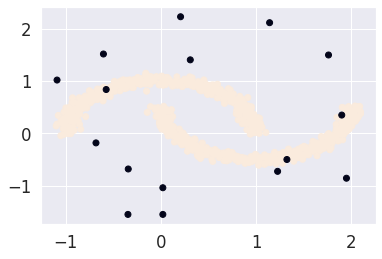

In [6]:
plt.scatter(*X_train.T, c=y_train)

### Problem statement

Anomaly detection problem statement: train function $\hat{f}:\mathcal{X}\to \mathbb{R}$ on dataset $\mathcal{S}$, such that

  * $\hat{f}(x) \leq 0$, where $x$ -- **normal** observation, $\hat{f}(x) > 0$ -- **anomal**;

  * with low rate of **misses**: $\hat{f}(x) \leq 0$ for **anomal** $x$;

  * and low rate of **false alarms**: $\hat{f}(x) > 0$ for **normal** $x$.

The exact representation $\mathcal{S}$ could vary depending on problem:


**...sometimes we have labels**

  * i.e. $\mathcal{S} = (x_i, y_i)_{i=1}^m$ where $y_i\in \{\pm 1\}$ are __anomaly__ labels;
  * <span style="color: red">**BUT** </span> normal observations are dominant class:
  $$
    \overbrace{\lvert i\colon y_i = +1 \rvert}^{n_+}
        \ll \overbrace{\lvert i\colon y_i = -1 \rvert}^{n_-}
    \,. $$


$\color{red}{\Rightarrow}$ **imbalanced classification**

**...sometimes we don't have labels

  * $\mathcal{S} = (x_i)_{i=1}^m$ -- **no labels!**;

  * predict $\alpha \in (0, 1)$ -- level of anomalies.


$\color{red}{\Rightarrow}$ **outlier detection**

### Metrics

We are going to use accuracy, precision, recall and $f1$-score to assess the quality of the model:

* **accuracy**

![pr_rc](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/525px-Precisionrecall.svg.png)


$$
    F_\beta
        = (1 + \beta^2)
            \frac{\text{Precision} \cdot \text{Recall}}
                 {\beta^2 \, \text{Precision} + \text{Recall}}
        = \frac{\beta + \beta^{-1}}{\beta\frac{1}{\text{Recall}} + \beta^{-1}\frac{1}{\text{Precision}}}
\,. $$

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

<br>

## 1.2 Elliptic Envelope

In [8]:
from sklearn.covariance import EllipticEnvelope

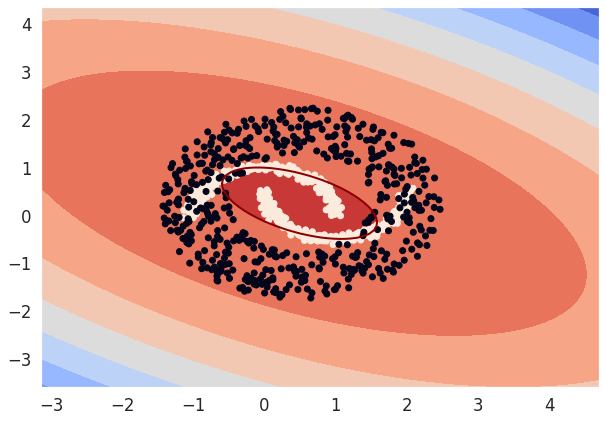

In [9]:
model = EllipticEnvelope(assume_centered=False, contamination=0.5)

model.fit(X_train)

plot_level_lines(model, X_test, y_test)

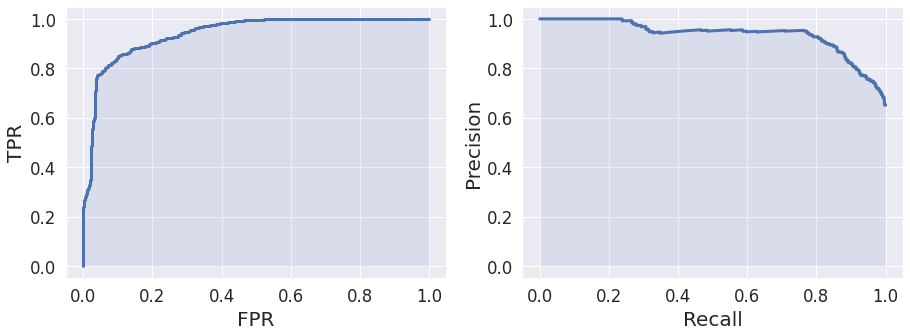

              precision    recall  f1-score   support

         0.0       0.99      0.53      0.69       512
         1.0       0.68      0.99      0.81       512

    accuracy                           0.76      1024
   macro avg       0.83      0.76      0.75      1024
weighted avg       0.83      0.76      0.75      1024



In [10]:
model = EllipticEnvelope(contamination=0.01)
model.fit(X_train)
predictions_elliptic = model.decision_function(X_test)
labels_elliptic = model.predict(X_test)


plot_results(y_test, predictions_elliptic)

metrics_elliptic = classification_report(y_test, (predictions_elliptic > 0) * 1, output_dict=True)
print(classification_report(y_test, (labels_elliptic > 0) * 1))

Pros:

* simple to use;
* interpretable decision boundary. 


Cons:

* good only for single mode distributions;
* covariance matrix could become singular.

## 1.3 Isolation Forest

At the basis of the Isolation Forest algorithm there is the tendency of anomalous instances in a dataset to be easier to separate from the rest of the sample (isolate), compared to normal points. () Wiki

![isoforest](https://i.stack.imgur.com/O59d4.png)

![](https://content.linkedin.com/content/dam/engineering/site-assets/images/blog/posts/2019/08/IsolationForest1.png)

In [11]:
from sklearn.ensemble import IsolationForest

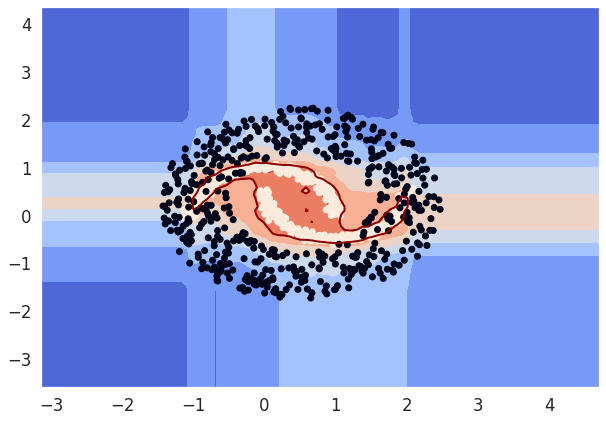

In [12]:
model = IsolationForest(n_estimators=100,
                        contamination=0.1,
                        max_features=1.0,
                        max_samples=1.0,
                        bootstrap=True,
                        random_state=0)
model.fit(X_train)

plot_level_lines(model, X_test, y_test)

In [13]:
model = IsolationForest()
model.fit(X_train)
predictions_isolation = model.decision_function(X_test)
labels_isolation = model.predict(X_test)

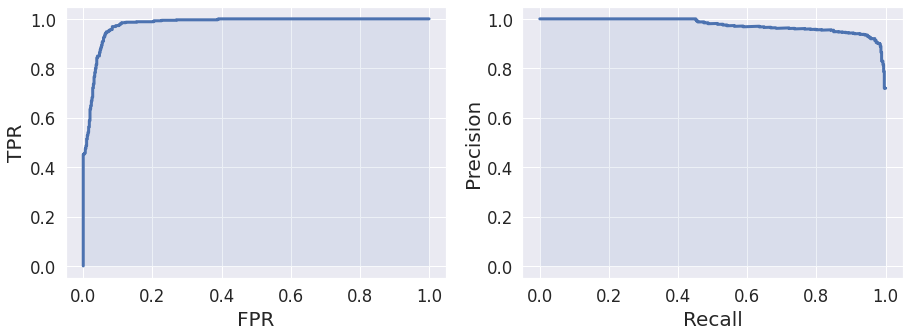

              precision    recall  f1-score   support

         0.0       0.82      0.96      0.89       512
         1.0       0.96      0.79      0.87       512

    accuracy                           0.88      1024
   macro avg       0.89      0.88      0.88      1024
weighted avg       0.89      0.88      0.88      1024



In [14]:
plot_results(y_test, predictions_isolation)

metrics_isolation = classification_report(y_test, (labels_isolation > 0) * 1, output_dict=True)
print(classification_report(y_test, (labels_isolation > 0) * 1))

Pros:

* Robust.

Cons:
* hard to interpret.

## 1.4 Local Outlier Factor

The local outlier factor is based on a concept of a local density, where locality is given by k nearest neighbors, whose distance is used to estimate the density. (c) wiki

* introduce local density variable, that inversely proportional to the mean distance to k nearest neighbours;

* compair local density of the object with local density for neighbours;

* clalculate local anomaly score.

<img src="https://upload.wikimedia.org/wikipedia/commons/4/4e/LOF-idea.svg" alt="drawing" width="600"/>

In [15]:
from sklearn.neighbors import LocalOutlierFactor

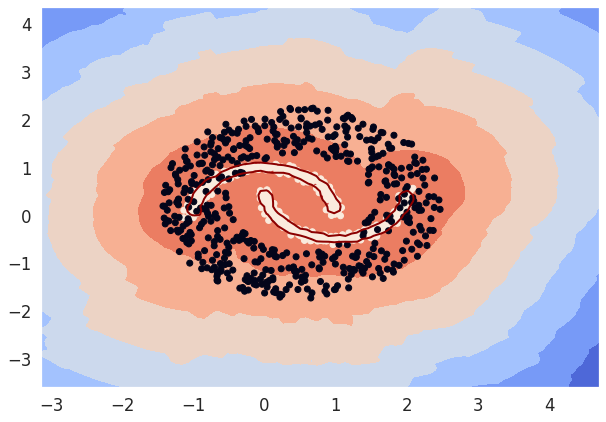

In [16]:
model = LocalOutlierFactor(n_neighbors=20, 
                           contamination=0.1,
                           metric='minkowski',
                           novelty=True,
                           p=2)
model.fit(X_train)

plot_level_lines(model, X_test, y_test)

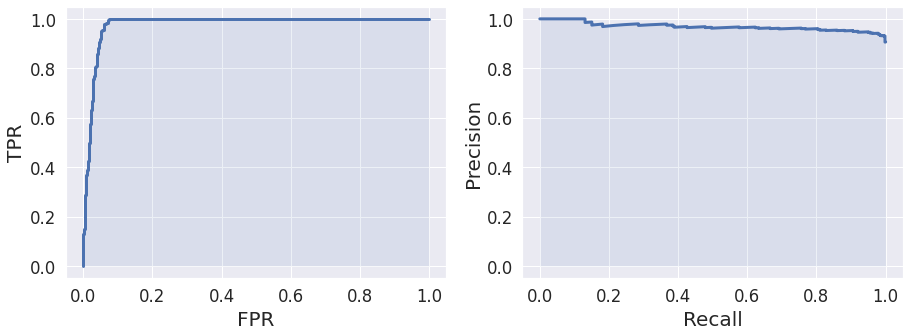

              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96       512
         1.0       0.93      0.99      0.96       512

    accuracy                           0.96      1024
   macro avg       0.96      0.96      0.96      1024
weighted avg       0.96      0.96      0.96      1024



In [17]:
model = LocalOutlierFactor(contamination=0.02)
model.fit(X_train)
predictions_lof = model._decision_function(X_test)
labels_lof = predictions_lof


plot_results(y_test, predictions_lof)

metrics_lof = classification_report(y_test, (labels_lof > 0) * 1, output_dict=True)
print(classification_report(y_test, (labels_lof > 0) * 1))

Pros:
    
* non-parametric method.

Cons:
    
* affected by the curse of dimensionality;
* can't distinguish anomaly clusters from normal clusters; 
* need to be trained for each new datasample, i.e. long inference time.

## 1.5 One Class SVM


\begin{aligned}
  & \underset{\rho, f\in \mathcal{H}}{\min}
    & & \tfrac12 \|f\|^2 - \rho
        + \tfrac1{m \nu} \sum_{i=1}^m \max\bigl\{
            0, \rho - f(x_i) \bigr\}\,,
\end{aligned}

Visualization for linear One-Class SVM: http://rvlasveld.github.io/blog/2013/07/12/introduction-to-one-class-support-vector-machines/

Visualization of RBF One-Class SVM: https://bitquill.net/blog/quick-hack-visualizing-rbf-bandwidth/


<img src="https://www.researchgate.net/profile/Andre_Marquand/publication/51462279/figure/fig2/AS:269979568308226@1441379553695/Illustration-of-the-OC-SVM-with-RBF-kernel-In-this-case-finding-the-smallest-hypersphere.png"  width="600">

In [18]:
from sklearn.svm import OneClassSVM

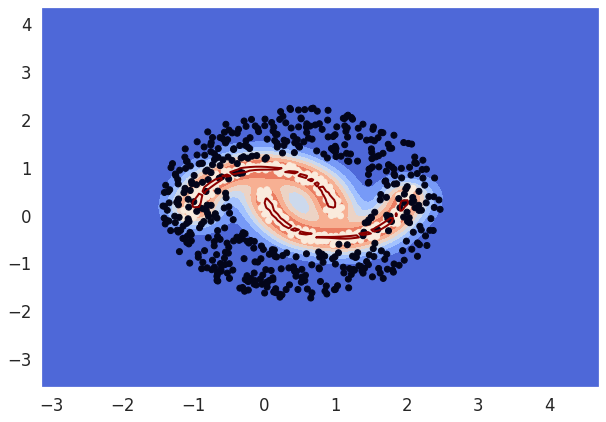

In [19]:
model = OneClassSVM(nu=0.5, kernel='rbf', gamma=10.)

model.fit(X_train)

plot_level_lines(model, X_test, y_test)

In [20]:
model = OneClassSVM(nu=0.5, kernel='rbf', gamma=10.)
model.fit(X_train)
predictions_svm = model.decision_function(X_test)
labels_svm = model.predict(X_test)

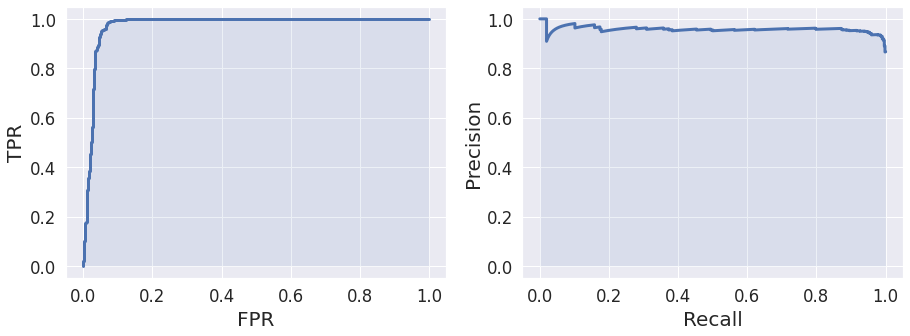

              precision    recall  f1-score   support

         0.0       0.66      0.98      0.79       512
         1.0       0.95      0.50      0.65       512

    accuracy                           0.74      1024
   macro avg       0.81      0.74      0.72      1024
weighted avg       0.81      0.74      0.72      1024



In [21]:
plot_results(y_test, predictions_svm)
metrics_svm = classification_report(y_test, (labels_svm > 0) * 1, output_dict=True)
print(classification_report(y_test, (labels_svm > 0) * 1))

Pros:

* non-parametric method;
* kernel can be defined for any type of object
    * graphs, texts;
* can be extremely powerful if kernel appropriately chosen.

Cons:
* computationally demand during training;
* stores training dataset in-memory for inference stage.

<br>

## 1.6 XGBoost classifier

In [22]:
from xgboost import XGBClassifier

estimator = XGBClassifier()

grid = {
    "learning_rate" : np.logspace(-2., 0., 10),
    "n_estimators": np.linspace(10, 200, 5, dtype=np.int)
}

In [23]:
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import make_scorer

f1_scorer = make_scorer(f1_score)

We are going to use statified $k$-fold.

In [24]:
from sklearn.model_selection import StratifiedKFold

st_kfold = StratifiedKFold(n_splits=5)

In [25]:
cv_grid = GridSearchCV(estimator, grid, scoring=f1_scorer, cv=st_kfold, n_jobs=-1, verbose=2)

cv_grid.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    3.8s


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    5.7s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     mis...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             n_jobs=-1,
             par

In [26]:
cv_grid.best_params_

{'learning_rate': 0.5994842503189409, 'n_estimators': 10}

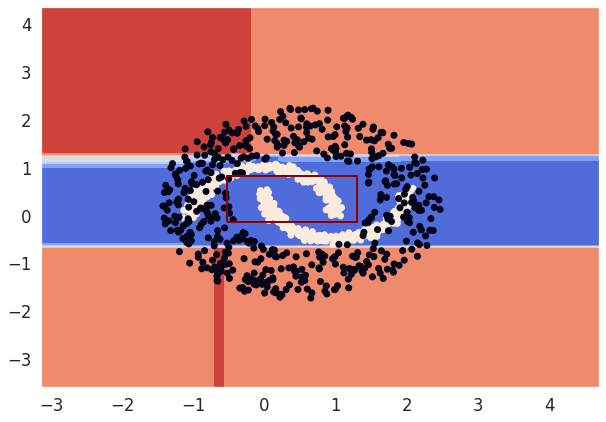

In [27]:
xgboost_classifier = cv_grid.best_estimator_
xgboost_test_pred = xgboost_classifier.predict_proba(X_test)[:, 1]
plot_level_lines(xgboost_classifier, X_test, y_test)

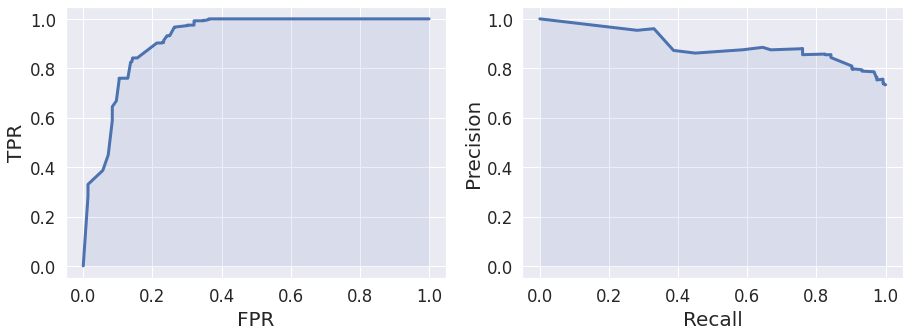

              precision    recall  f1-score   support

         0.0       1.00      0.56      0.72       512
         1.0       0.70      1.00      0.82       512

    accuracy                           0.78      1024
   macro avg       0.85      0.78      0.77      1024
weighted avg       0.85      0.78      0.77      1024



In [28]:
plot_results(y_test, xgboost_test_pred)
metrics_xgboost = classification_report(y_test, (xgboost_test_pred > 1.) * 1., output_dict=True)
print(classification_report(y_test, (xgboost_test_pred > 0.5) * 1.))

# 2. Profile quality of methods as a function of threshold

In [29]:
isolation_forest_reports = {}
xgb_reports = {}
train_size_negs = np.logspace(0.5, 3, 20, dtype=np.int)

for train_size_neg in tqdm.tqdm_notebook(train_size_negs):
    X_train, y_train, _, _ = create_dataset_moons(
        train_size_pos=1024, train_size_neg=train_size_neg, test_size=512
    )
    xgb = XGBClassifier(learning_rate=0.07, n_estimators=57)
    xgb.fit(X_train, y_train)
    xgb_test = xgb.predict(X_test)
    xgb_reports[train_size_neg] = classification_report(y_test, xgb_test, output_dict=True)
    
    isolation_forest = IsolationForest()
    isolation_forest.fit(X_train)
    isolation_forest_reports[train_size_neg] = classification_report(y_test, (isolation_forest.predict(X_test) > 0) * 1, output_dict=True)

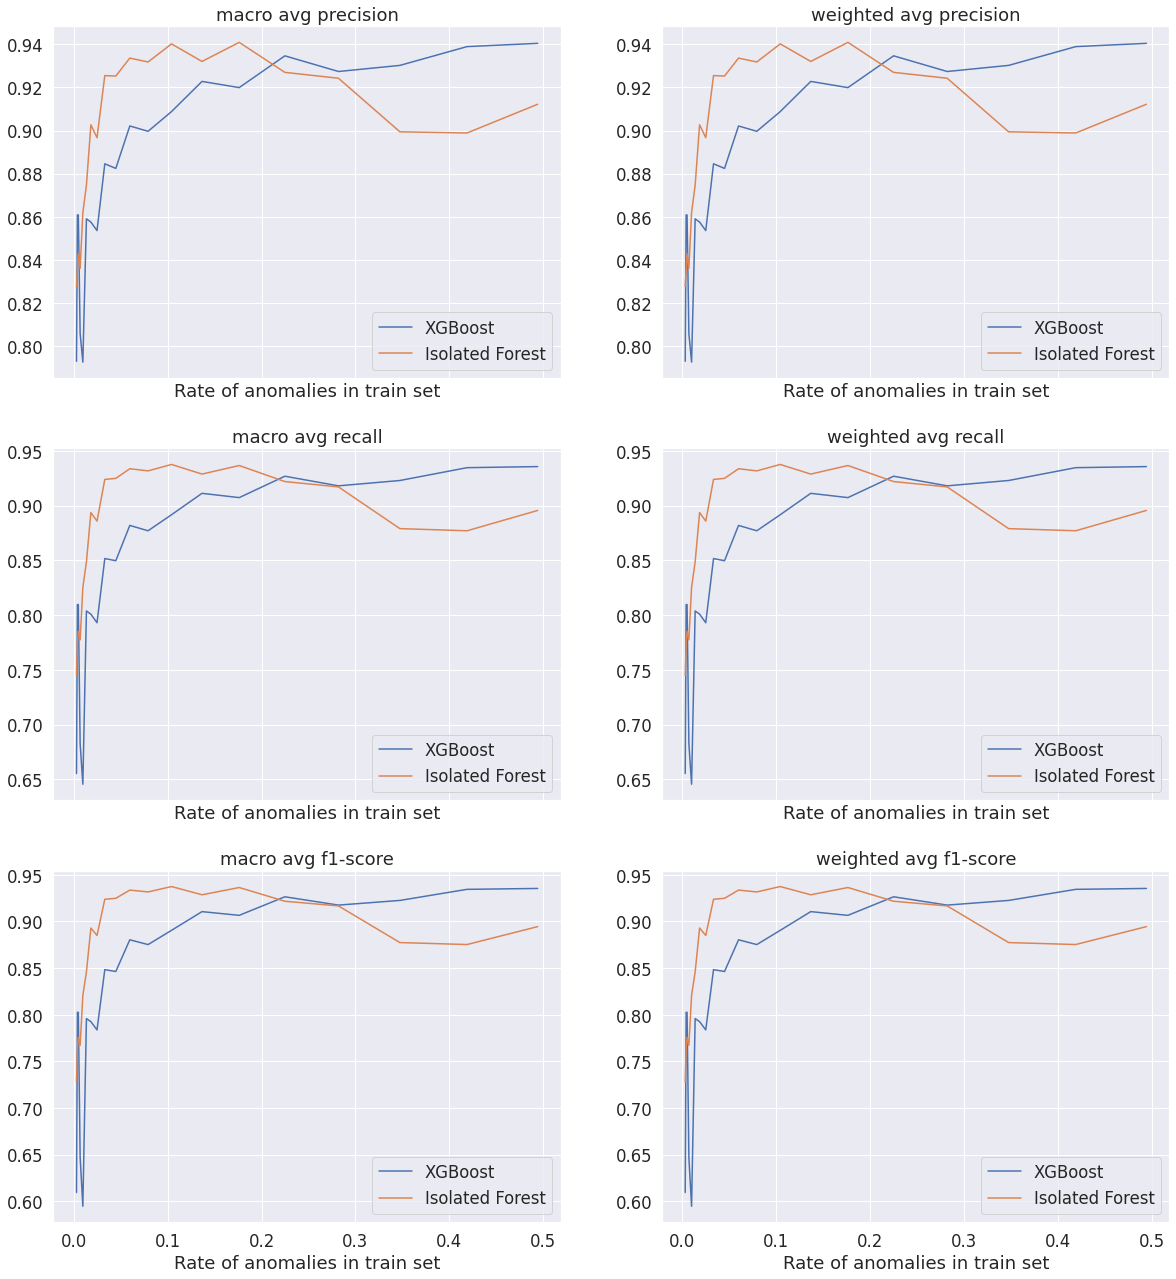

In [30]:
fig, ax = plt.subplots(3, 2, sharex=True, figsize=(20, 22))
i = 0

for average in ["macro avg", "weighted avg"]:
    for metric in ["precision", "recall", "f1-score"]:
        xgb_metric = []
        isolated_metric = []
        for train_size_neg in train_size_negs:
            xgb_metric.append(
                xgb_reports[train_size_neg][average][metric]
            )
            isolated_metric.append(
                isolation_forest_reports[train_size_neg][average][metric]
            )
        ax[i % 3][i // 3].plot((train_size_negs) / (1024 + train_size_negs), xgb_metric, label="XGBoost")
        ax[i % 3][i // 3].plot((train_size_negs) / (1024 + train_size_negs), isolated_metric, label="Isolated Forest")
        ax[i % 3][i // 3].set_title("{} {}".format(average, metric))
        ax[i % 3][i // 3].legend()
        ax[i % 3][i // 3].set_xlabel("Rate of anomalies in train set")
        i += 1
plt.show()